In [1]:
%matplotlib inline
from IPython.core.display import display, HTML, Javascript

html_contents ="""
<!DOCTYPE html>
<html lang="en">
    <head>
        <link rel="stylesheet" href="https://www.w3schools.com/w3css/4/w3.css">
        <link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Raleway">
        <link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Oswald">
        <link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Open Sans">
        <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
        <style>
        .title-section{
            font-family: "Oswald", Arial, sans-serif;
            font-weight: bold;
            color: "#6A8CAF";
            letter-spacing: 6px;
        }
        hr { border: 1px solid #E58F65 !important;
             color: #E58F65 !important;
             background: #E58F65 !important;
           }
        body {
            font-family: "Open Sans", sans-serif;
            }        
        </style>
    </head>    
</html>
"""

HTML(html_contents)

# <span class="title-section w3-xxlarge" id="codebook">PurgedGroupTimeSeries CV with Extra Data</span>
This is a simple starter notebook for Kaggle's Crypto Comp showing purged group timeseries KFold with extra data. Purged Times Series is explained [here][2]. There are many configuration variables below to allow you to experiment. Use either GPU or TPU. You can control which years are loaded, which neural networks are used, and whether to use feature engineering. You can experiment with different data preprocessing, model architecture, loss, optimizers, and learning rate schedules. The extra datasets contain the full history of the assets at the same format of the competition, so you can input that into your model too.

**NOTE:** this notebook lets you run a different experiment in each fold if you want to run lots of experiments. (Then it is like running multiple holdout validaiton experiments but in that case note that the overall CV score is meaningless because LB will be much different when the multiple experiments are ensembled to predict test). **If you want a proper CV with a reliable overall CV score you need to choose the same configuration for each fold.**

This notebook follows the ideas presented in my "Initial Thoughts" [here][1]. Some code sections have been reused from Chris' great notebook series on SIIM ISIC melanoma detection competition [here][3]

[1]: https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/284903
[2]: https://www.kaggle.com/yamqwe/let-s-talk-validation-grouptimeseriessplit
[3]: https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords

# <span class="title-section w3-xxlarge" id="codebook">Kaggle's G-Research Crypto Forecasting</span>
In this competition, we need to forecast returns of cryptocurrency assets. Full description [here][1]. This is a very challenging time series task as seen by looking at the sample data below.

[1]: https://www.kaggle.com/c/g-research-crypto-forecasting/overview

In [2]:
import pandas as pd
import plotly.graph_objects as go
crypto_df = pd.read_csv("../input/g-research-crypto-forecasting/" + 'train.csv')
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp")
btc_mini = btc.iloc[-200:]
fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

# <span class="title-section w3-xxlarge" id="codebook">Initialize Environment</span>

In [3]:
import os
import traceback
import gresearch_crypto
import tensorflow as tf
import pandas as pd, numpy as np
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# <span class="title-section w3-xxlarge" id="codebook">Configuration</span>
In order to be a proper cross validation with a meaningful overall CV score, **you need to choose the same** `INC2021`, `INC2020`, `INC2019`, `INC2018`, `INC2017`, `INCCOMP`, `INCSUPP`, and `DEPTH_NETS`, `WIDTH_NETS` **for each fold**. If your goal is to just run lots of experiments, then you can choose to have a different experiment in each fold. Then each fold is like a holdout validation experiment. When you find a configuration you like, you can use that configuration for all folds.
* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* INC2021 - This controls whether to include the extra historical prices during 2021.
* INC2020 - This controls whether to include the extra historical prices during 2020.
* INC2019 - This controls whether to include the extra historical prices during 2019.
* INC2018 - This controls whether to include the extra historical prices during 2018.
* INC2017 - This controls whether to include the extra historical prices during 2017.
* INCCOMP - This controls whether to include the original data of the competition.
* INCSUPP - This controls whether to include the supplemented train data that was released with the competition.
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* DEPTH_NETS - is a list of length FOLDS. These are the Network Depths to use each fold. The number refers to the number of layers. So a number of `1` refers to 1 layer, and `2` refers to 2 layers, etc.
* WIDTH_NETS - is a list of length FOLDS. These are the Network Widths to use each fold. The number refers to the number of units per layer. So a number of `32` refers to 32 per layer, and `643` refers to 64 layers, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.

In [4]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. 
FOLDS = 5
# GAP FROM SPLIT TO SPLIT [SEE DETAILS ABOUT THE CV]
GROUP_GAP = 31

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2021 = 0
INC2020 = 1
INC2019 = 0
INC2018 = 0
INC2017 = 0
INCCOMP = 1
INCSUPP = 0

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [2048] * FOLDS
EPOCHS = [1] * FOLDS

# WHICH NETWORK ARCHITECTURE TO USE?
DEPTH_NETS = [2, 2, 2, 2, 2] 
WIDTH_NETS = [64, 64, 64, 64, 64]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1 / FOLDS] * FOLDS

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except: print("failed to initialize TPU")
    else: DEVICE = "GPU"

if DEVICE != "TPU": strategy = tf.distribute.get_strategy()
if DEVICE == "GPU": print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

connecting to TPU...
Num GPUs Available:  1


2021-11-11 14:52:45.796003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 14:52:45.926816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 14:52:45.927731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# <span class="title-section w3-xxlarge" id="codebook">Step 1: Data Loading</span>
The data organisation has already been done and saved to Kaggle datasets. Here we choose which years to load. We can use either 2017, 2018, 2019, 2020, 2021, Original, Supplement by changing the `INC2021`, `INC2020`, `INC2019`, `INC2018`, `INC2017`, `INCCOMP`, `INCSUPP` variables in the preceeding code section. These datasets are discussed [here][1].

[1]: https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/285726


In [6]:
orig_df_train = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/train.csv')
supp_df_train = pd.read_csv('../input/g-research-crypto-forecasting/supplemental_train.csv')
df_asset_details = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/asset_details.csv').sort_values("Asset_ID")

extra_data_files = {
                        0: '../input/cryptocurrency-extra-data-binance-coin',
                        2: '../input/cryptocurrency-extra-data-bitcoin-cash',
                        1: '../input/cryptocurrency-extra-data-bitcoin',
                        3: '../input/cryptocurrency-extra-data-cardano',
                        4: '../input/cryptocurrency-extra-data-dogecoin',                        
                        5: '../input/cryptocurrency-extra-data-eos-io',
                        6: '../input/cryptocurrency-extra-data-ethereum',
                        7: '../input/cryptocurrency-extra-data-ethereum-classic', 
                        8: '../input/cryptocurrency-extra-data-iota',
                        9: '../input/cryptocurrency-extra-data-litecoin',
                        11: '../input/cryptocurrency-extra-data-monero',
                        10: '../input/cryptocurrency-extra-data-maker',
                        12: '../input/cryptocurrency-extra-data-stellar',
                        13: '../input/cryptocurrency-extra-data-tron'
                   }

def load_training_data_for_asset(asset_id):
    dfs = []        
    if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
    if INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())    
    if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'))
    if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'))
    if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'))
    if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'))
    if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'))
    df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
    df['date'] = pd.to_datetime(df['timestamp'], unit = 's')        
    df = df.sort_values('date')
    return df


# <span class="title-section w3-xxlarge" id="codebook">Step 2: Feature Engineering</span>
This notebook uses upper_shadow, lower_shadow, high_div_low, open_sub_close, seasonality/datetime features first shown in this notebook [here][1] and successfully used by julian3833 [here][2].

Additionally we can decide to use external data by changing the variables `INC2021`, `INC2020`, `INC2019`, `INC2018`, `INC2017`, `INCCOMP`, `INCSUPP` in the preceeding code section. These variables respectively indicate whether to load last year 2021 data and/or year 2020, 2019, 2018, 2017, the original, supplemented data. These datasets are discussed [here][3]

Consider experimenting with different feature engineering and/or external data. The code to extract features out of the dataset is taken from julian3833' notebook [here][2]. Thank you julian3833, this is great work.

[1]: https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition
[2]: https://www.kaggle.com/julian3833
[3]: TBD

In [7]:
# Two features from the competition tutorial
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat["open_sub_close"] = df_feat["Open"] - df_feat["Close"]
    return df_feat

# <span class="title-section w3-xxlarge" id="codebook">Step 3: Build Model</span>
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers.

In [8]:
def build_model(fold, dim = 128):
    inp = tf.keras.layers.Input(shape=(dim))
    x = inp
    
    for i in range(DEPTH_NETS[fold]):
        x = tf.keras.layers.Dense(WIDTH_NETS[fold])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs = inp, outputs = x)
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer=opt, loss='mse')
    return model

# <span class="title-section w3-xxlarge" id="codebook">Step 4: Train Schedule</span>
This is a common train schedule in kaggle competitions. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [9]:
def get_lr_callback(batch_size = 8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        else: lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [10]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

# <span class="title-section w3-xxlarge" id="codebook">Train Model</span>
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variable `VERBOSE`. The variable `VERBOSE=1 or 2` will display the training and validation loss for each epoch as text. 

In [11]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1

def get_Xy_and_model_for_asset(asset_id):
    df = load_training_data_for_asset(asset_id)
    df_proc = get_features(df)
    df_proc['date'] = df['date'].copy()
    df_proc['y'] = df['Target']
    df_proc = df_proc.dropna(how="any")
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]
    groups = pd.factorize(X['date'].dt.day.astype(str) + '_' + X['date'].dt.month.astype(str) + '_' + X['date'].dt.year.astype(str))[0]
    X = X.drop(columns = 'date')
    oof_preds = np.zeros(len(X))
    scores, models = [], []
    model=build_model(0,11)
    model.load_weights('../input/purgedgrouptimeseries-cv-with-extra-data-nn/fold-0.h5')
    return X,y,model

X,y,model=get_Xy_and_model_for_asset(13)

2021-11-11 14:53:32.533490: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 14:53:32.534985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 14:53:32.535745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 14:53:32.536421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                768       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0     

In [13]:
keys=X.keys()

In [14]:
X=tf.Variable(X)
y=tf.Variable(y)
with tf.GradientTape() as tape:
    tape.watch(X)
    pred=model(X)
grad=tf.abs(tape.gradient(pred,X))

2021-11-11 14:53:34.965762: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 163112048 exceeds 10% of free system memory.


In [15]:
grad.shape

TensorShape([1853546, 11])

In [16]:
grad=tf.reduce_mean(grad,axis=0)

In [17]:
grad.shape

TensorShape([11])

<BarContainer object of 11 artists>

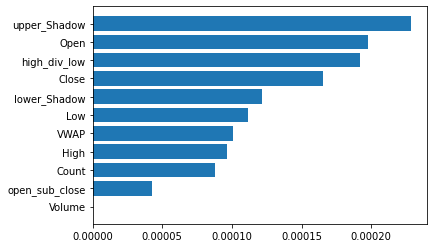

In [18]:
import matplotlib.pyplot as plt
# the more impotance more longer bars

#plt.figure(figsize=(10,20))
plt.barh(np.array(list(keys))[np.argsort(grad)],np.sort(grad))